In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import shuffle

#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
sepsis_survival_minimal_clinical_records = fetch_ucirepo(id=827) 
  
# data (as pandas dataframes) 
X = sepsis_survival_minimal_clinical_records.data.features 
y = sepsis_survival_minimal_clinical_records.data.targets 

In [137]:
def create_balanced_subsample(X, y):
    """
    Create a balanced subsample by randomly undersampling the majority class.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The feature matrix
    y : array-like of shape (n_samples,)
        The target vector with binary values (0 and 1)
    
    Returns:
    --------
    X_balanced : array-like
        The balanced feature matrix
    y_balanced : array-like
        The balanced target vector
    """
    # Get indices for each class
    alive_indices = np.where(y == 1)[0]
    dead_indices = np.where(y == 0)[0]
    
    # Get the size of the minority class
    n_minority = len(dead_indices)
    
    # Randomly sample from majority class
    alive_indices_subsampled = np.random.choice(
        alive_indices, 
        size=n_minority, 
        replace=False
    )
    
    # Combine indices
    balanced_indices = np.concatenate([alive_indices_subsampled, dead_indices])
    
    # Shuffle the combined indices
    balanced_indices = shuffle(balanced_indices)
    
    # Create balanced datasets
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    print("Original class distribution:")
    print(f"Class 1 (alive): {len(alive_indices)}")
    print(f"Class 0 (dead): {len(dead_indices)}")
    print("\nBalanced class distribution:")
    print(f"Class 1 (alive): {sum(y_balanced == 1)}")
    print(f"Class 0 (dead): {sum(y_balanced == 0)}")
    
    return X_balanced, y_balanced

# Usage:
#X_balanced, y_balanced = X.values, y.values.flatten()
X_balanced, y_balanced = create_balanced_subsample(X.values, y.values.flatten())
#y_balanced = 1-y_balanced

Original class distribution:
Class 1 (alive): 102212
Class 0 (dead): 8129

Balanced class distribution:
Class 1 (alive): 8129
Class 0 (dead): 8129


In [138]:
clf_list = ['GB', 'KNN', 'RF', 'XGB', 'LR']
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 10 
results_df = pd.DataFrame() 

for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in clf_list: 
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator

running model search


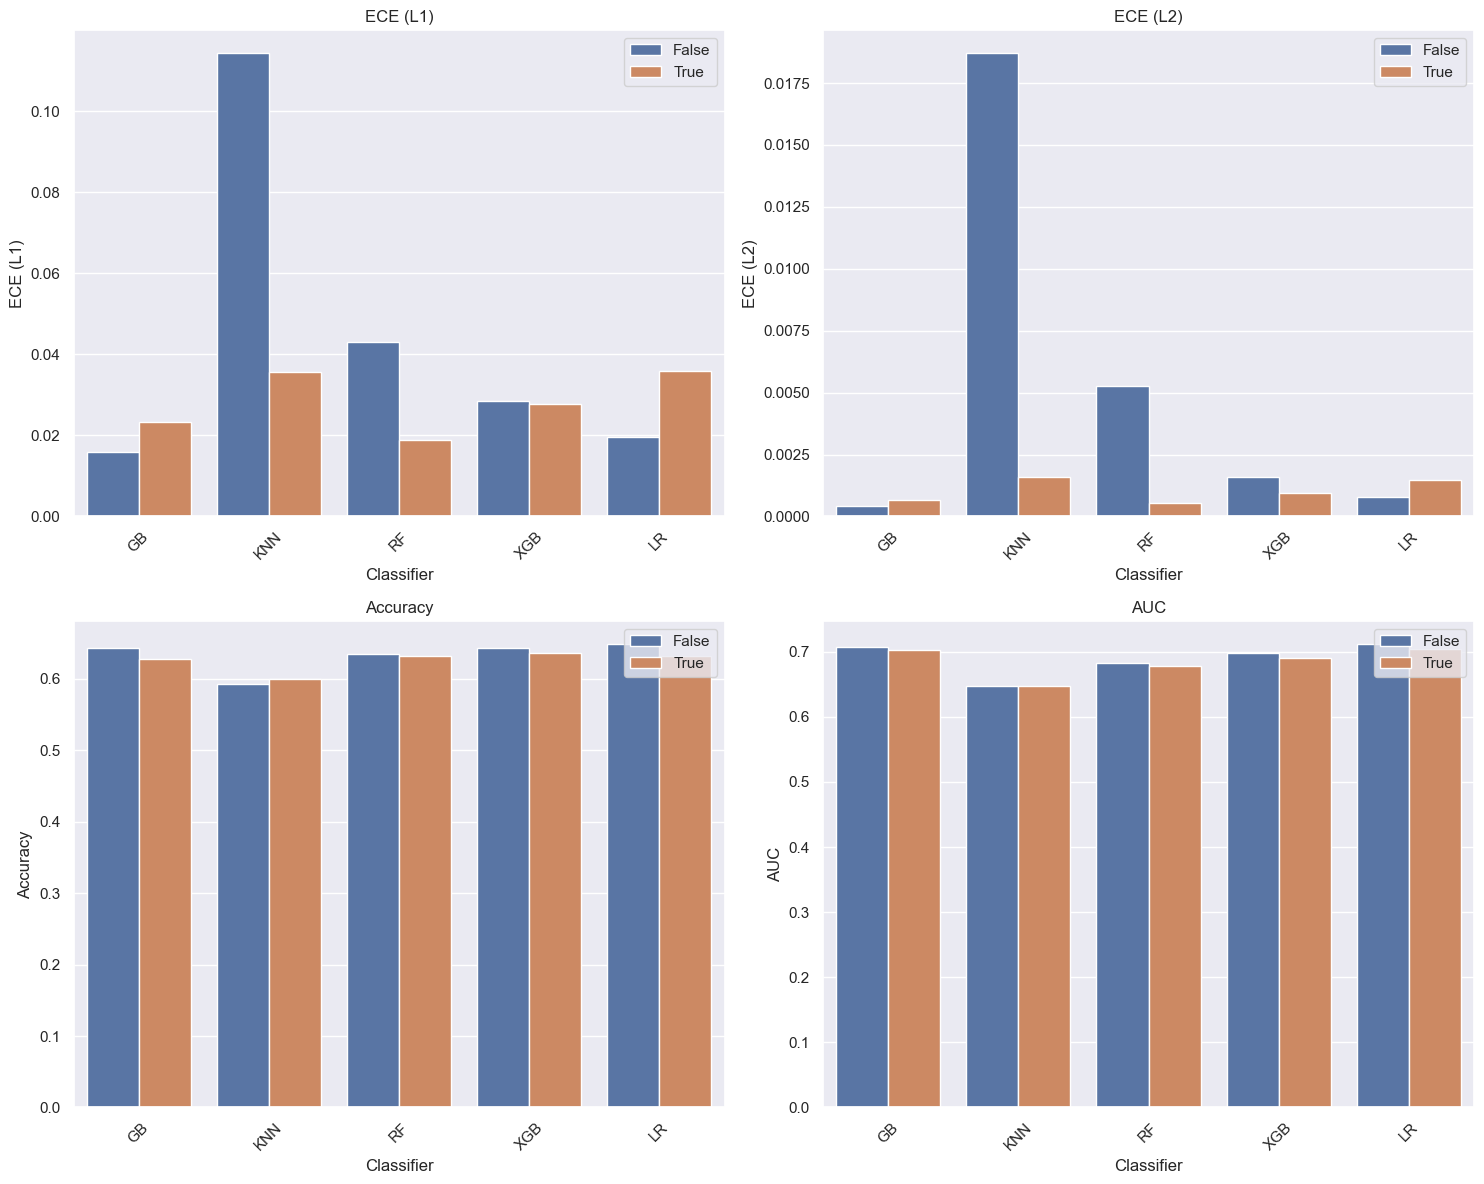

In [139]:
training_results_df = pd.DataFrame(training_results)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

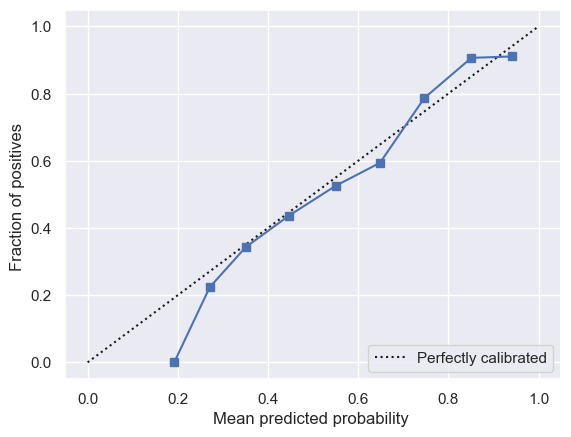

In [140]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

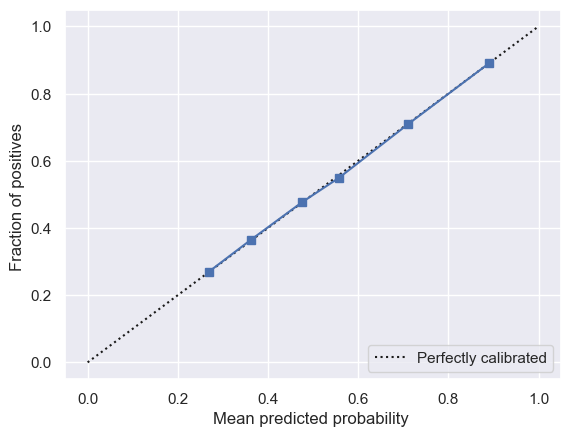

In [141]:
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
calibrator = cal.HistogramCalibrator()
calibrator.calibrate(y_prob=y_prob, 
                     y_true=y_valid)
cal_valid_probs = calibrator.transform(y_prob)
        
prob_true, prob_pred = calibration_curve(y_valid, cal_valid_probs, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, cal_valid_probs)
disp.plot()

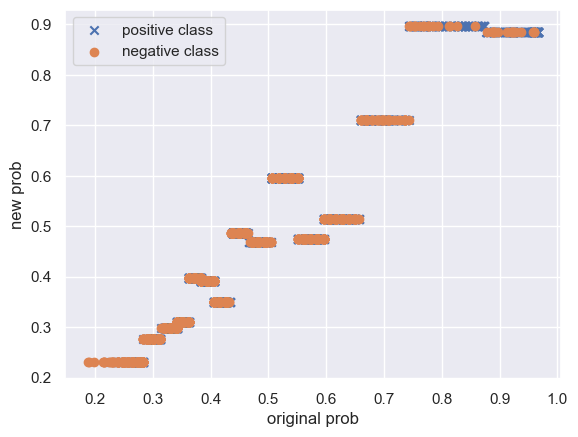

In [142]:
mask = y_valid ==1 
plt.scatter(y_prob[mask], cal_valid_probs[mask], marker='x', label='positive class')
plt.scatter(y_prob[~mask], cal_valid_probs[~mask], marker='o', label='negative class')
plt.xlabel("original prob")
plt.ylabel("new prob")
plt.legend()

In [143]:
w1 = 0.3
w0 = 0.2 
alpha = 0.1

beta = alpha/(1-alpha) * (w1)/(w1+w0)

X_test_sample = X_test[:100]
y_test_sample = y_test[:100]
binary_pred = curr_clf.predict(X_test_sample)
binary_order = np.argsort(binary_pred)[::-1]
binary_pred = binary_pred[binary_order]
binary_true = y_test_sample[binary_order]

cal_probs = calibrator.transform(curr_clf.predict_proba(X_test_sample)[:, 1])
cal_order = np.argsort(cal_probs)[::-1]
cal_probs = cal_probs[cal_order]
cal_pred = cal_probs > beta
cal_true = y_test_sample[cal_order]

In [144]:
X_bin, Y_bin, Z_bin = get_performance_stats(predicted_priority=binary_pred, 
                                            true_priority=binary_true)
X_cal, Y_cal, Z_cal = get_performance_stats(predicted_priority=cal_pred,
                                            true_priority=cal_true)

print(X_bin, Y_bin, Z_bin)
print(X_cal, Y_cal, Z_cal)

(array([0, 1]), array([20, 28]))
(array([0, 1]), array([50, 50]))
371 210 740
832 1275 0


In [145]:
print(f"bin CR: {get_CR(alpha=alpha, w0=w0, w1=w1, X=X_bin, Y=Y_bin, Z=Z_bin)}")
print(f"cal CR: {get_CR(alpha=alpha, w0=w0, w1=w1, X=X_cal, Y=Y_cal, Z=Z_cal)}")

bin CR: 85.61999999999999
cal CR: 42.14000000000001


In [146]:
def get_CR(alpha:float, 
           w0: float, 
           w1: float,
           X: int, 
           Y: int, 
           Z: int) -> float: 
    return alpha*w0*(X+Y) + (w1-w0)*Z
    
def get_performance_stats(predicted_priority: np.ndarray,
                          true_priority: np.ndarray) -> (int, int, int):
    # needs to be ordered 
    mask = predicted_priority== 1 
    high_pred_label = true_priority[mask]
    print(np.unique(high_pred_label, return_counts=True))
    #Number of inversions of high and low priority jobs among jobs predicted to be high priority.
    X, Y, Z = 0, 0, 0
    for i in range(len(high_pred_label)): 
        for j in range(i, len(high_pred_label)): 
            if high_pred_label[i] == 0: 
                if high_pred_label[j] == 1: 
                    X+=1 
                elif high_pred_label[j] == 0:
                    Y+=1
    # can be 1 loop but this is more readable
    for i in range(len(true_priority)): 
        for j in range(i, len(true_priority)): 
            if true_priority[i] == 0 and true_priority[j] == 1: 
                Z+=1 
    Z = Z - X 
    return X, Y, Z

In [147]:
y_train.mean(), y_test.mean()

(np.float64(0.5040369088811996), np.float64(0.49907749077490776))